# IMPLEMETING CIRCUS ALGORITHM
The CIRCUS algorithm is a solver of Linear Programming optimization which uses the idea of circumcenters together with
some techniques applied in the Simplex algorithm. In this notebook, I'll implement the Simplex first, then
implement the **trial version** of the CIRCUS.

In [124]:
using Plots, LinearAlgebra

Plots.PyPlotBackend()

## SIMPLEX
Let's use as example the following case:
$$
\begin{aligned}
\textrm{Maximize} \quad & x_1 + x_2 \\
\textrm{Subject to} \quad &
        -x_1 + x_2  &\leq 1\\
\quad & x_1        &\leq 3\\
\quad & x_2         &\leq 2\\
\quad & x_1,x_2     &\geq 0
\end{aligned}
$$

We then put this in the standard form by adding slack variables:
$$
\begin{aligned}
\textrm{Maximize} \quad & x_1 + x_2 \\
\textrm{Subject to} \quad &
        -x_1 + x_2 + x_3  &= 1\\
\quad & x_1 + x_4        &= 3\\
\quad & x_2 + x_5         &= 2\\
\quad & x_1,x_2,x_3,x_4,x_5     &\geq 0
\end{aligned}
$$

Therefore we have:
$$
\begin{aligned}
\textrm{Maximize} \quad & c^T {x} \\
\textrm{Subject to} \quad & Ax = b \\
\quad & x\geq 0
\end{aligned}
$$

First, we will implement the Simplex Method following the book "Understanding and Using Linear Programming".

In [641]:
A = [-1 1 1 0 0;
      1 0 0 1 0;
      0 1 0 0 1 ]
c = [1,1,0,0,0]
b = [1,3,2]
# starting basic feasible point
xo = [0,0,1,3,2];

function SimplexFromBFS(c,A,b,initial_bfs;max_iterations=100,index_bfs=[0],index_nfs = [0])
    # Initial setup
    e  = 10^-5
    B  = findall(xo .> 0+e)
    N  = findall(xo .<= 0+e)
    if size(A[:,B])[1] != size(A[:,B])[2]
        B = index_bfs
        N = index_nfs
    end
    xn = initial_bfs[N]; xb = initial_bfs[B];
    
    # Simplex pivoting iteration
    for i = 1:max_iterations
        Ab = A[:,B]; An = A[:,N]; cb = c[B]; cn = c[N]
        p  = inv(Ab)*b
        Q  = -inv(Ab)*An
        r  = (cb'*Q + cn')'
        if all(r.<= 0)
            x_final = vcat(hcat(B,p),hcat(N,zeros(length(N))))
            x_final = x_final[sortperm(x_final[:,1]),:]
            return x_final
        end
        zo = cb'*p
#         z  = zo + r'*xn
        index_in =findmax(r)[2]
        x_in = N[index_in]
        if any(Q[:,index_in] .< 0)
            coef_entering = -p./Q[:,index_in] 
            q_neg_index   = findall(Q[:,index_in] .< 0)
            index_out     =findfirst(coef_entering .== findmin(coef_entering[q_neg_index])[1])
            x_out     = B[index_out]
            B[index_out] = x_in
            N[index_in]  = x_out
        else
            
            error("Unbounded")
        end
        println(x_in,"   ",x_out)
    end
    x_final = vcat(hcat(B,p),hcat(N,zeros(length(N))))
    x_final = x_final[sortperm(x_final[:,1]),:]
    return x_final
end


SimplexFromBFS (generic function with 1 method)

In [642]:
SimplexFromBFS(c,A,b,xo)

1   4
2   5


5×2 Array{Float64,2}:
 1.0  3.0
 2.0  2.0
 3.0  2.0
 4.0  0.0
 5.0  0.0

### Degenerte example

In [453]:
A = [-1 1 1 0 ;
      1 0 0 1]
c = [0,1,0,0]
b = [0,2]
# starting basic feasible point
xo = [0,0,0,1];
SimplexFromBFS(c,A,b,xo;max_iterations=10,index_bfs=[3,4],index_nfs=[1,2])

2   3
1   4


4×2 Array{Float64,2}:
 1.0  2.0
 2.0  2.0
 3.0  0.0
 4.0  0.0

### CIRCUS 

In [747]:
function CC(S)
    # Function to calculate the circumcenter
    T1 = (S.-S[:,1])[:,2:end]
    T2 = pinv(T1' * T1) # MODIFIED THE ORIGINAL BY THE PSEUDO-INVERSE INSTEAD OF THE INVERSE. IT SEEMS TO WORK... WHY?
    T3 = diag((S.-S[:,1])[:,2:end]' * (S.-S[:,1])[:,2:end])
    cc = S[:,1] + 0.5.*T1 * T2 * T3
    return cc
end

CC (generic function with 1 method)

xp very close to the optimal solution


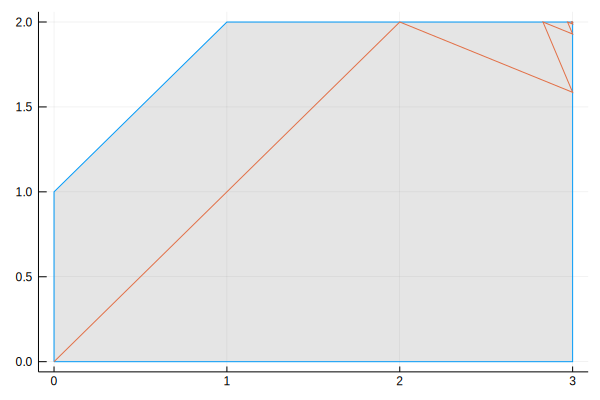

In [1204]:
function CIRCUS(c,Ag,b,initial_point;tolerance=10^-4, max_iterations=100)
    
    norm_row(A,d=2) = sqrt.(sum(abs2,A,dims=d))
    xo = convert(Array{Float64},initial_point)
    xp = [xo]
    
    Ag_normalized = Ag ./ norm_row(Ag)
    c_normalized = c ./ norm(c)
    
    for i = 1:max_iterations
        J = findall(Ag*xo - b .== 0) # Active restrictions
        I = setdiff(1:size(Ag)[1],J) # Inactive restrictions
        angles  = Ag_normalized[J,:]*c_normalized
        J_acute = angles .< 0
        qtd_acute_restrictions = sum(J_acute)
        
        if size(J)[1] - qtd_acute_restrictions == 0
            circum = CC(Ag_normalized[J,:])
        else
            drop_index = findmin(angles)[2]
            if size(J)[1] == 1
                J_c = J
            else
                J_c = J[1:end .!= drop_index]
            end
            circum = CC(hcat(-c_normalized,Ag_normalized[J_c,:]'))
        end

        eq   = (b[I]-Ag[I,:]*xo) ./ (Ag[I,:]*(-circum))
        eq[eq .< 0] .= Inf
        replace!(eq, NaN=>Inf)
        
        α, J = findmin(eq)
        J    = findall(eq .== α)
        J    = I[J] # new Active restrictions
        I = setdiff(1:size(Ag)[1],J) # new Inactive restrictions
    
        push!(xp,xo-α*circum)
        #Check feasibility
        if sum(Ag*xp[end] .<= b) != size(Ag)[1]
            println("xp not feasible, hence, xo is the optimal solution")
            return xp
        else
            ϵ = norm(xp[end] - xo)
            if ϵ < tolerance
                println("xp very close to the optimal solution")
                return xp
            end
        end
        xo = xp[end]
    end
    println("Maximum iteration limit reached.")
    return xp
end

xo = [0,0]
xp = CIRCUS(c,Ag,b,xo)
xp = hcat(xp...)'
plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
plot!(xp[:,1],xp[:,2])

In [1216]:
xo = [1,0]
xp = CIRCUS(c,Ag,b,xo)
xp = hcat(xp...)'
plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
plot!(xp[:,1],xp[:,2])

DimensionMismatch: DimensionMismatch("matrix A has dimensions (4,2), vector B has length 1")

In [1094]:
norm_row(A,d=2) = sqrt.(sum(abs2,A,dims=d))

tolerance = 10^-3
xo = [0,0]
xo = [0,1]
xo = [3,1]
Ag = [-1 0;0 -1;-1 1;0 1;1 0]
Ag_normalized = Ag ./ norm_row(Ag)
c = [1,1]
c_normalized = c ./ norm(c)
b = [0,0,1,2,3];
# starting basic feasible point
J = findall(Ag*xo - b .== 0) # Active restrictions
# J = [2,3]
I = setdiff(1:size(Ag)[1],J) # Inactive restrictions
angles  = Ag_normalized[J,:]*c_normalized
J_acute = angles .< 0
qtd_acute_restrictions = sum(J_acute)
if size(J)[1] - qtd_acute_restrictions == 0
    println("Basic Feasible Solution acute")
    circum = CC(Ag_normalized[J,:])
# elseif qtd_acute_restrictions == 0
#     println("Optimal solution!")
else
    println("BFS with objective function c")
    drop_index = findmin(angles)[2]
    if size(J)[1] == 1
        J_c = J
    else
        J_c = J[1:end .!= drop_index]
    end
    circum = CC(hcat(-c_normalized,Ag_normalized[J_c,:]'))
end

eq   = (b[I]-Ag[I,:]*xo) ./ (Ag[I,:]*(-circum))
eq[eq .< 0] .= Inf
replace!(eq, NaN=>Inf)
α, J = findmin(eq)
J    = findall(eq .== α)
J    = I[J] # new Active restrictions
I = setdiff(1:size(Ag)[1],J) # new Inactive restrictions
xp = xo - α*circum

#Check feasibility

if sum(Ag*xp .<= b) != size(Ag)[1]
    println("xp not feasible, hence, xo is the optimal solution")
else
    ϵ = norm(xp - xo)
    if ϵ < tolerance
        pritln("xp very close to the optimal solution")
    end
end
plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
quiver!([xo[1],xo[1]],[xo[2],xo[2]],quiver=(Ag[1:2,1],Ag[1:2,2]),xlims=[-5,5],ylims=[-5,5])
quiver!([xo[1]],[xo[2]],quiver=([-circum[1]],[-circum[2]]),xlims=[-5,5],ylims=[-5,5])
plot!([xo[1],xp[1]],[xo[2],xp[2]],marker=true)

BFS with objective function c


1.0823922002923938

BFS with objective function c


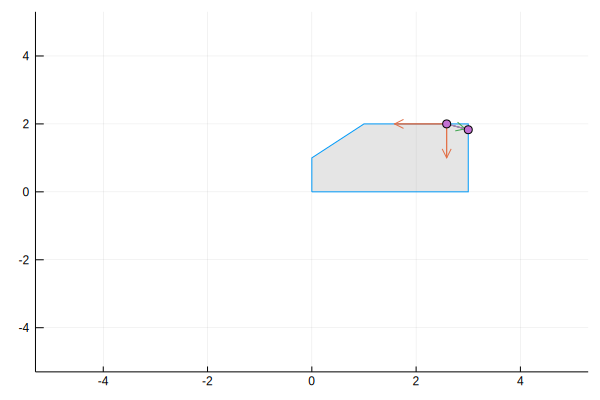

In [1064]:
xo = xp
Ag = [-1 0;0 -1;-1 1;0 1;1 0]
Ag_normalized = Ag ./ norm_row(Ag)
c = [1,1]
c_normalized = c ./ norm(c)
b = [0,0,1,2,3];
# starting basic feasible point
J = findall(Ag*xo - b .== 0) # Active restrictions
# J = [2,3]
I = setdiff(1:size(Ag)[1],J) # Inactive restrictions
angles  = Ag_normalized[J,:]*c_normalized
J_acute = angles .< 0
qtd_acute_restrictions = sum(J_acute)
if size(J)[1] - qtd_acute_restrictions == 0
    println("Basic Feasible Solution acute")
    circum = CC(Ag_normalized[J,:])
# elseif qtd_acute_restrictions == 0
#     println("Optimal solution!")
else
    println("BFS with objective function c")
    drop_index = findmin(angles)[2]
    if size(J)[1] == 1
        J_c = J
    else
        J_c = J[1:end .!= drop_index]
    end
    circum = CC(hcat(-c_normalized,Ag_normalized[J_c,:]'))
end

eq   = (b[I]-Ag[I,:]*xo) ./ (Ag[I,:]*(-circum))
eq[eq .< 0] .= Inf
replace!(eq, NaN=>Inf)
α, J = findmin(eq)
J    = findall(eq .== α)
J    = I[J] # new Active restrictions
I = setdiff(1:size(Ag)[1],J) # new Inactive restrictions
xp = xo - α*circum
plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
quiver!([xo[1],xo[1]],[xo[2],xo[2]],quiver=(Ag[1:2,1],Ag[1:2,2]),xlims=[-5,5],ylims=[-5,5])
quiver!([xo[1]],[xo[2]],quiver=([-circum[1]],[-circum[2]]),xlims=[-5,5],ylims=[-5,5])
plot!([xo[1],xp[1]],[xo[2],xp[2]],marker=true)